In [1]:
import numpy as np                                     
import matplotlib.pyplot as plt                      
import pandas as pd

from Functions_Load_smooth_data import *
from Functions_for_Data_Analysis import *
from Functions_for_Plots import *
plt.rcParams["font.family"] = "Arial"
import sys
import seaborn as sns
sys.path.append('../../')
from Functions_common_for_model_and_experiments import *
from Functions_for_plot_style import *
%load_ext autoreload
%autoreload 2

# Load and smooth the p53 traces

In [2]:
file_path="Input_files/"
file_out_path = "Output_files/"
fig_path = "Figures/"
parameters = pd.read_csv(file_path+"Parameters.csv",index_col=0, delimiter=',',header=0)

dataset_dict = []
titles = parameters["filename"].tolist()
for n in np.arange(0,len(titles),1): #### Choose external frequency   
    # Load the data
    matrix_of_traces = np.array(pd.read_csv(file_path+"p53_from"+titles[n]+".txt", delimiter=',',header=None))
    for cell in range(matrix_of_traces.shape[0]):
        dataset_dict.append(
            {"filename": titles[n],
             "cell_id": cell, 
             "p53_trace":matrix_of_traces[cell,:]}
        )

In [3]:
# Creates the pandas dataframe and merges with the parameters of the experiment
dataset = pd.DataFrame(dataset_dict)                                        
dataset = pd.merge(dataset,parameters, on = ["filename"], how = 'left')     

# Splits the dataset in three zones (before, during and after nutlin pulses), 
# find the position of the nutlin pulses from the parameters of the experiments 
# and define the nutlin square wave for the plots,
# Normalize cells to 1st point
dataset = dataset.apply(normalize_traces_to_first_point,axis=1)
dataset = dataset.apply(split_trajectories_in_3_zones,axis=1)
dataset = dataset.apply(compute_position_nutlin_pulses, axis=1)
dataset = dataset.apply(compute_nutlin_square_signal,axis = 1)

# Smoothing and filtering of the data
dataset = dataset.apply(subtract_poly_fit, axis=1)
dataset = dataset.apply(smooth_filter_median, axis = 1)
dataset = dataset.apply(smooth_filter_polyn, axis = 1)

# Saves the dataset in .pkl file
dataset.to_pickle(file_out_path+"Dataset.pkl")

In [4]:
# Shows how many cells we have for each experiment
group_sizes = dataset.groupby(['nutlin_period [hour]','nutlin_concentration [uM]']).size()

In [5]:
group_sizes

nutlin_period [hour]  nutlin_concentration [uM]
2.50                  0.50                         260
4.00                  0.50                         207
7.00                  0.50                         232
8.00                  0.50                         200
9.17                  0.50                         228
11.00                 0.25                         200
                      0.50                         222
                      1.00                         202
                      2.00                          37
dtype: int64

## Data analysis

In [6]:
dataset = pd.read_pickle(file_out_path+"Dataset.pkl")

# Compute the position of the p53 peaks, the peak-to-peak-distance and classify the entrainment type
dataset = dataset.apply(compute_peaks, axis = 1)
dataset = dataset.apply(compute_peak_to_peak_distance, axis = 1)
dataset = dataset.apply(find_entrainment_type,axis=1)

# Group the dataset by entrain label: "Entrained", "Period-doubling", "Mode-hopping", "Unclassified"
dataset_grouped_by_entrain_label = group_df(dataset, "entrain_label")
dataset_grouped_by_entrain_label = dataset_grouped_by_entrain_label[["Entrained", 
                                                                   "Period-doubling",
                                                                   "Mode-hopping",
                                                                     "Unclassified"]]# This reorders the columns

# Group the dataset by entrain mode: "Non-Entrained", "1:2", "1:1", "2:1", "3:2"
dataset_grouped_by_entrain_mode = group_df(dataset,"entrain_mode")

In [7]:
# Find couple of traces that have same initial behaviour for chaos
rows_cols_unique = find_traces_that_start_together(dataset, 
                                nut_period = 11,
                                nut_conc = 0.5,
                                entrain_label = "Unclassified",
                                entrain_mode = "Non-entrained", 
                                num_traces_to_find = 30, 
                                initial_points_to_compare = 10)

# Plots

## Figure 2B, top: 1:1 entrainment in experimental traces

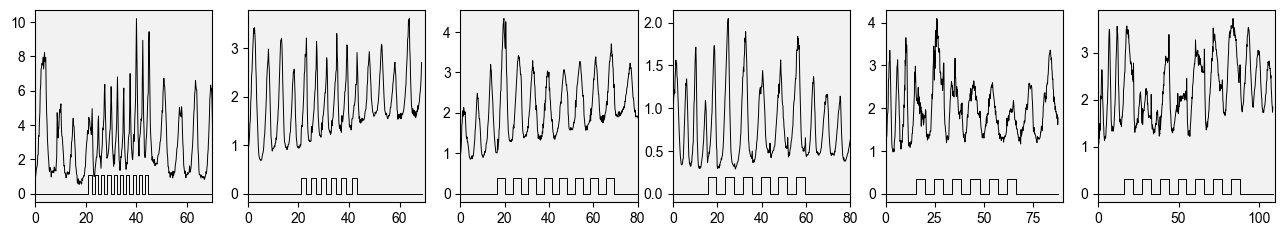

In [8]:
simTvec = [70,70,80,80,90,110]
cell_ids = [120,195,151,72,121,4]
periods = [2.5,4,7,8,9.17,11]
fig, axs = plt.subplots(1,len(periods),figsize=(16,2.5))
for i,cell_id in enumerate(cell_ids):
    plot_single_cells_allzones(fig,axs[i],dataset, 
                    nut_period = periods[i], 
                    nut_conc = 0.5, 
                    cell_id = cell_id,
                    bool_norm = True, 
                    entrain_label = "Entrained", 
                    entrain_mode = "1.0",
                    xlim_right = simTvec[i])
plt.savefig("./Figures/One_to_one_entrainment_different_per.svg")

## Supplementary Figure 2, top: 11 h traces

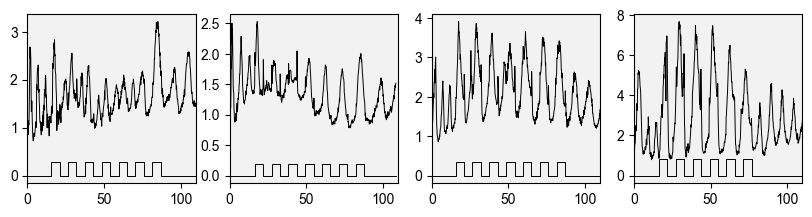

In [9]:
simTvec = [110,110,110,110,100,110]
cell_ids = [0,166,26,22]
nut_conc = [0.25,0.5,1.0,2.0]
modes = ["2.0", "1.0", "1.0", "1.0"]
fig, axs = plt.subplots(1,len(nut_conc),figsize=(10,2.2))
for i,cell_id in enumerate(cell_ids):
    plot_single_cells_allzones(fig,axs[i],dataset, 
                    nut_period = 11, 
                    nut_conc = nut_conc[i], 
                    cell_id = cell_id,
                    bool_norm = True, 
                    entrain_label = "Entrained", 
                    entrain_mode = modes[i],
                    xlim_right = simTvec[i])
plt.savefig("./Figures/One_to_one_entrainment_different_nut.svg")

## Figure 2C-D, heatmaps

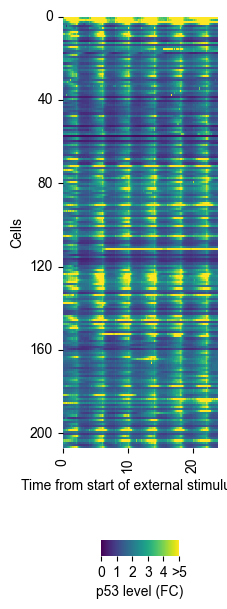

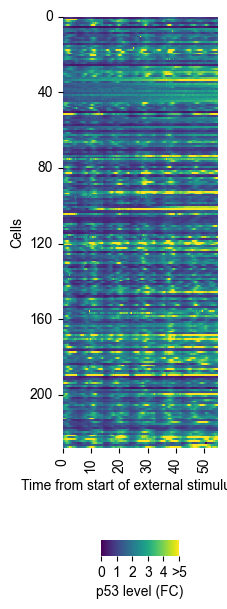

In [10]:
# Convert the array of arrays to a 2D array
nut_periods = [4,9.17]
xticks_list =(np.array([0,10,20]),np.array([0,10,20,30,40,50]))
yticks_list=[0,40,80,120,160,200]
colorbar_ticks = [0, 1, 2, 3, 4, 5]
colorbar_tick_labels = ['0', '1', '2', '3', '4', '>5']
for i,nut_per in enumerate(nut_periods):
    subset = dataset[dataset["nutlin_period [hour]"]==nut_per]
    plot_heatmap(subset, 
                 yticks_list,
                 xticks_list[i],
                 colorbar_ticks,
                 colorbar_tick_labels,
                 fig_path,
                 nut_per)

## Supplementary Figure 2, heatmaps

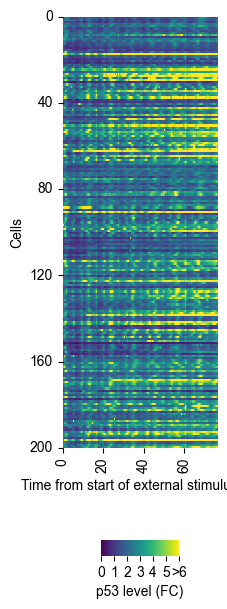

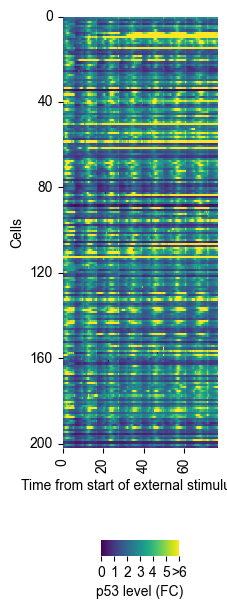

In [11]:
# Convert the array of arrays to a 2D array
nut_conc_vec = [0.25,1.0]
xticks_list =np.array([0,20,40,60])
yticks_list = [0,40,80,120,160,200]
colorbar_ticks = [0, 1, 2, 3, 4, 5, 6]
colorbar_tick_labels = ['0', '1', '2', '3', '4', '5', '>6']
for i,nut_conc in enumerate(nut_conc_vec):
    subset = dataset[dataset["nutlin_concentration [uM]"]==nut_conc]
    plot_heatmap(subset, 
                 yticks_list,
                 xticks_list,
                 colorbar_ticks,
                 colorbar_tick_labels,
                 fig_path,
                 nut_conc)

## Figure 2C,D, average p53 traces

207
228


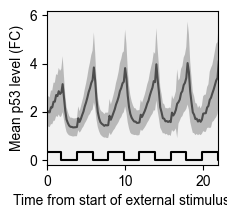

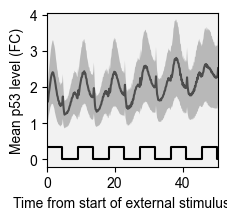

In [12]:
fig,ax = plt.subplots(figsize=(2.2,2))
plot_mean_trace_with_std(fig,ax,dataset,4,0.5, background_color, fig_path, True)
fig,ax = plt.subplots(figsize=(2.2,2))
plot_mean_trace_with_std(fig,ax,dataset,9.17,0.5, background_color, fig_path, True)

## Supplementary Figure 2, average p53 traces

200
202


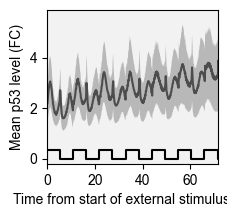

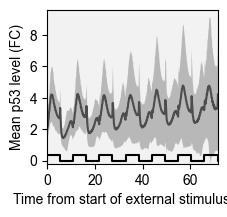

In [13]:
fig,ax = plt.subplots(figsize=(2.2,2))
plot_mean_trace_with_std(fig,ax,dataset,11,0.25, background_color, fig_path, True)
fig,ax = plt.subplots(figsize=(2.2,2))
plot_mean_trace_with_std(fig,ax,dataset,11,1.0, background_color, fig_path, True)

## Figure 3D-E and 4E-F: Histograms of entrain label and mode

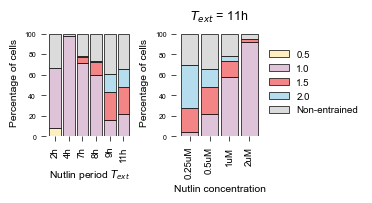

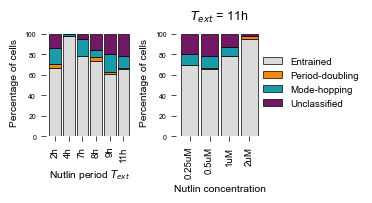

In [14]:
# Makes the histograms
make_histo(dataset_grouped_by_entrain_mode,
           color_list =  ["#FFEEBF","#DFC3D8","#F48586", "#B5DDED","#DBDBDB"],
          filename_tosave = fig_path+"Histo_entrain_mode")
make_histo(dataset_grouped_by_entrain_label,
           color_list = ["#DBDBDB","#F38713","#1B9AAA","#701864"],
          filename_tosave =fig_path+"Histo_entrain_label")

## Fig 4B: Mode-hopping traces

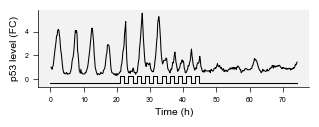

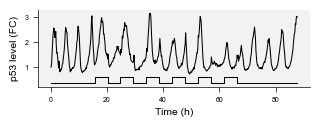

In [15]:
plot_mode_hopping_trace(dataset,
                        cell_id = 130,
                        nutlin_period = 2.5,
                        nutlin_concentration = 0.5,
                        offset_nut_pulses_in_plot = -10,
                        figure_path = fig_path,
                        bool_norm=True)

plot_mode_hopping_trace(dataset,
                        cell_id = 135,
                        nutlin_period = 9.17,
                        nutlin_concentration = 0.5,
                        offset_nut_pulses_in_plot = +0.6,
                        figure_path = fig_path,
                        bool_norm = True)

## Fig 4D: Period-doubling traces

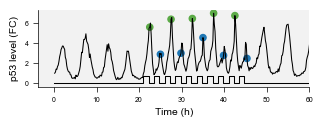

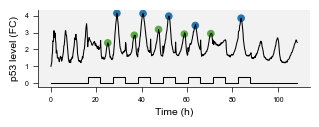

In [16]:
plot_period_doubling_trace(dataset,
                            cell_id = 5,
                            nutlin_period = 2.5,
                            nutlin_concentration = 0.5,
                            offset_nut_pulses_in_plot = 0,
                            xlim_right = 60,
                            figure_path = fig_path,
                            bool_norm = True)

plot_period_doubling_trace(dataset,
                            cell_id = 41,#170,
                            nutlin_period = 11,
                            nutlin_concentration = 0.5,
                            offset_nut_pulses_in_plot = 0,
                            xlim_right = None,
                            figure_path = fig_path,
                            bool_norm = True)




## Fig 4G-H: Histograms of unclassified vs entrained

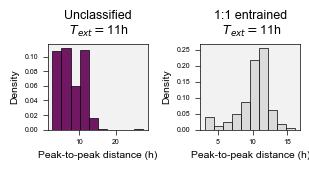

In [17]:
# Compares the peak-to-peak distance distribution of cells in the unclassified fraction vs 1:1 entrain mode
make_histo_periods_entrained_vs_unclassified(dataset, nut_period=11, nut_conc=0.5, entrain_mode= "1.0", figure_path = fig_path)

## Fig 5A-B: Chaotic traces

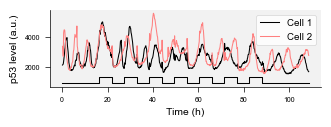

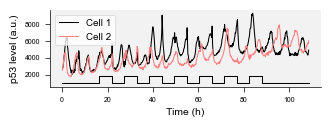

In [18]:
plot_chaos_traces(dataset,
                cell_ids = [12,20],
                nutlin_period = 11,
                nutlin_concentration = 0.5,
                offset_nut_pulses_in_plot = 0.7,
                figure_path = fig_path)

plot_chaos_traces(dataset,
                cell_ids = [80,143],
                nutlin_period = 11,
                nutlin_concentration = 0.5,
                offset_nut_pulses_in_plot = 0.7,
                figure_path = fig_path)

# Fig 5G: Period-1, period-2 and 1:1 traces at different nutlins

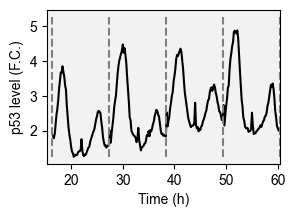

In [19]:
fig,ax = plt.subplots(figsize=(3,2))
plot_single_cell_trace_exp(fig,
                           ax,
                           dataset, 
                           cell_id = 188,
                           nutlin_period = 11,
                           nutlin_concentration = 0.5,
                           bool_norm=True,
                           min_p = 0,
                           max_p = -3)
plt.xlabel("Time (h)")
plt.ylabel("p53 level (F.C.)")
plt.savefig(fig_path+"period2_exp_05nut.svg")  #

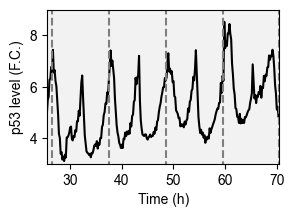

In [20]:
fig,ax = plt.subplots(figsize=(3,2))
plot_single_cell_trace_exp(fig,
                           ax,
                           dataset,
                           cell_id = 122,
                           nutlin_period = 11,
                           nutlin_concentration = 0.25,
                           bool_norm=True,
                           min_p = 1,
                           max_p = 5)
plt.ylim(3,9)
plt.xlabel("Time (h)")
plt.ylabel("p53 level (F.C.)")
plt.savefig(fig_path+"period2_exp_025nut.svg") 

37


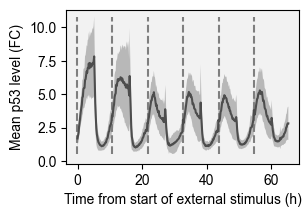

In [24]:
fig,ax = plt.subplots(figsize=(3,2))
nut_per = 11
nut_conc = 2.0
plot_mean_trace_with_std(fig,ax,dataset,nut_per, nut_conc, background_color, fig_path, False)

# Suppl Fig: Lyapunov exponent for experimental traces

Lyapunov exponent 0.1302+-0.02120611


(0.0, 50.0)

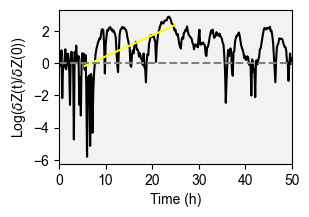

In [25]:
t2, x_xone2_cell1, _ = extract_cell_info_from_dataset(dataset, 
                                                      nutlin_period = 11,
                                                      nutlin_concentration = 0.5, 
                                                      cell_id = 12, 
                                                      zone = "Zone2",
                                                      bool_norm= False)
t2, x_xone2_cell2, _ = extract_cell_info_from_dataset(dataset, 
                                                      nutlin_period = 11,
                                                      nutlin_concentration = 0.5,
                                                      cell_id = 20,
                                                      zone = "Zone2",
                                                      bool_norm = False)

startpoint = 33 
endpoint = 150 

t = t2-t2[0]
mean_divergence = compute_lyap_div(x_xone2_cell1, x_xone2_cell2, t)
lyapunov_exp, lyapunov_exp_error, lyapunov_exp_intercept = compute_lyap_exp(timesteps = t,
                                                                            divergence = mean_divergence,
                                                                            startpoint = startpoint, 
                                                                            endpoint = endpoint)

plot_divergence_lyap_exp([], t, mean_divergence, startpoint, endpoint, lyapunov_exp, lyapunov_exp_intercept, lyapunov_exp_error,
                         alpha = 0.1, color_background = background_color, filename = fig_path+"Single_lyap_exponent_experimental.svg")
plt.xlim(left = 0, right=50)

### Experimental traces averaged

Lyapunov exponent 0.0802+-0.01038439


(0.0, 50.0)

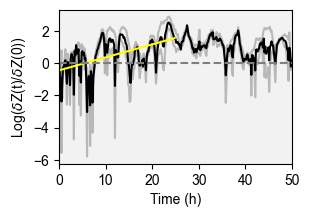

In [26]:
divergence_vec = []
cell_id_couple = [[12,20],[80,143]]
for i in range(2):
    t2, x_xone2_cell1, _ = extract_cell_info_from_dataset(dataset, 
                                                          nutlin_period = 11,
                                                          nutlin_concentration = 0.5,
                                                          cell_id = cell_id_couple[i][0],
                                                          zone = "Zone2",
                                                          bool_norm=False)
    t2, x_xone2_cell2, _ = extract_cell_info_from_dataset(dataset,
                                                          nutlin_period = 11,
                                                          nutlin_concentration = 0.5,
                                                          cell_id = cell_id_couple[i][1],
                                                          zone = "Zone2",
                                                          bool_norm=False)
    t = t2-t2[0]
    divergence_vec.append(compute_lyap_div(x_xone2_cell1, x_xone2_cell2, t))

mean_divergence = np.mean(divergence_vec, axis = 0)
startpoint = 0#33
endpoint = 150#50
lyapunov_exp, lyapunov_exp_error, lyapunov_exp_intercept = compute_lyap_exp(t,mean_divergence, startpoint = startpoint, endpoint = endpoint)

plot_divergence_lyap_exp(divergence_vec, t, mean_divergence, startpoint, endpoint,
                         lyapunov_exp, lyapunov_exp_intercept, lyapunov_exp_error,
                         0.5, color_background_exp, fig_path+"experimental_lyapunov.svg")
plt.xlim(left = 0, right=50)

# Visualize traces

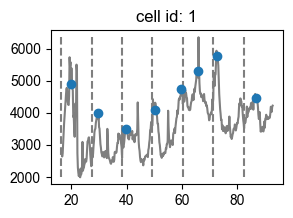

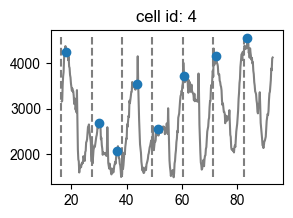

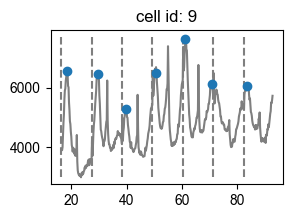

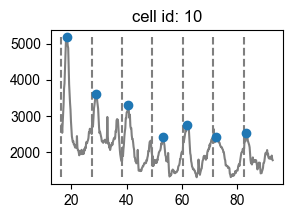

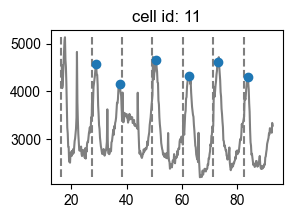

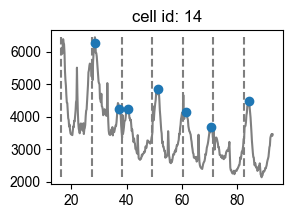

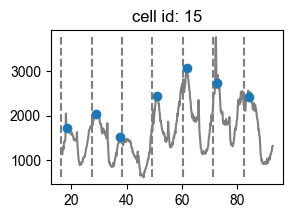

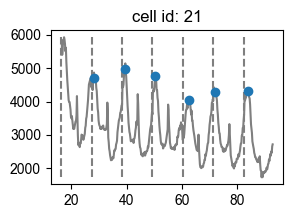

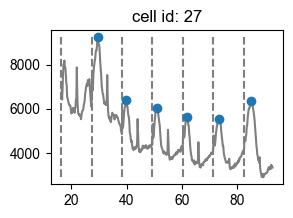

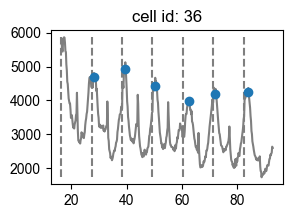

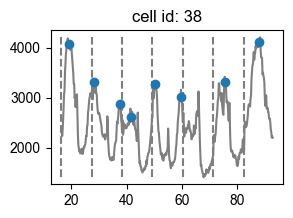

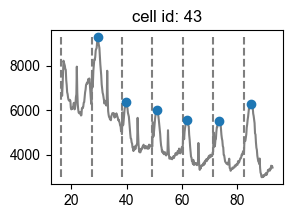

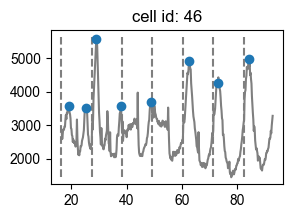

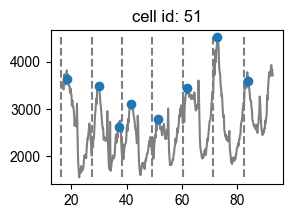

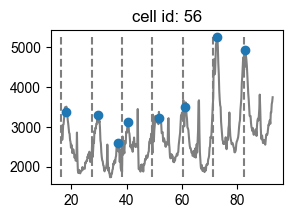

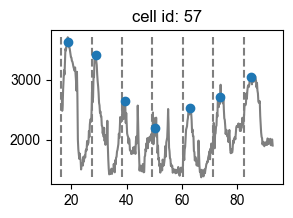

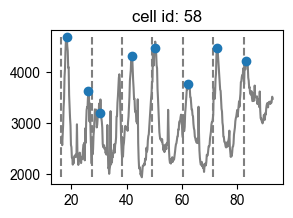

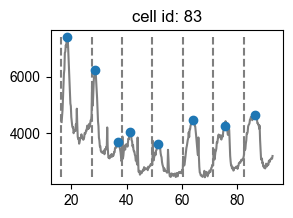

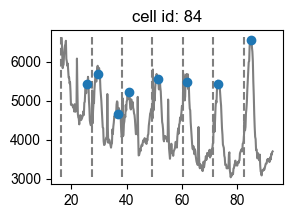

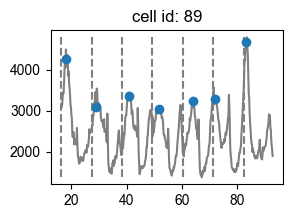

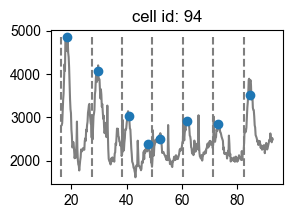

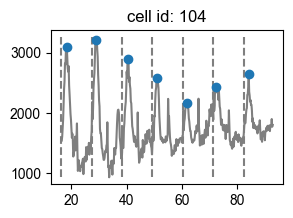

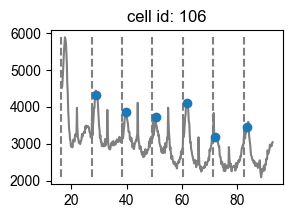

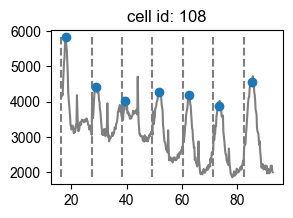

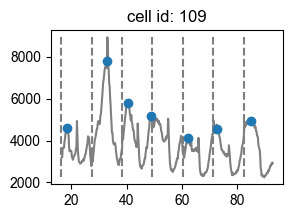

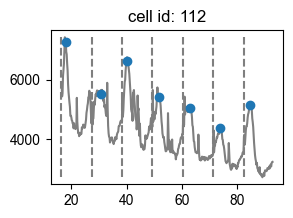

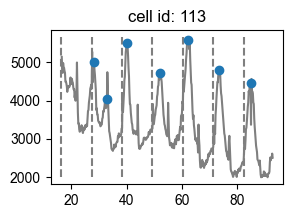

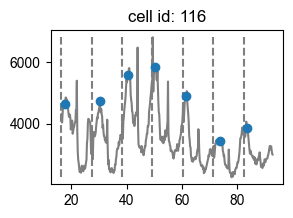

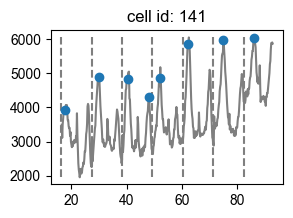

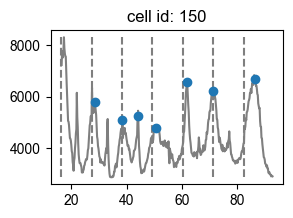

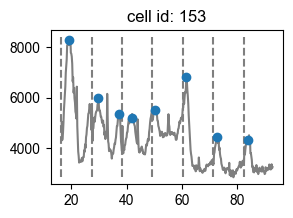

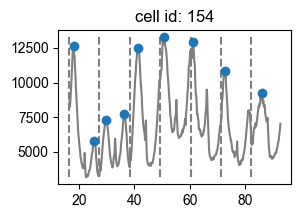

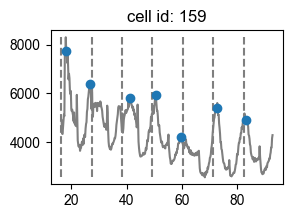

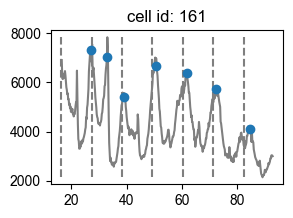

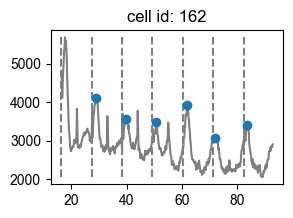

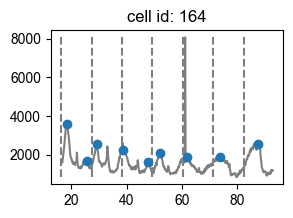

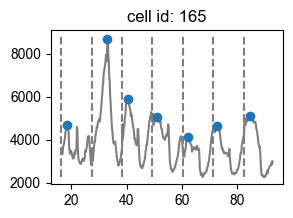

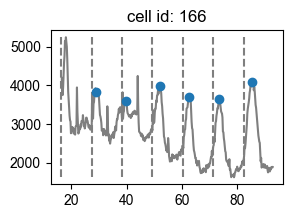

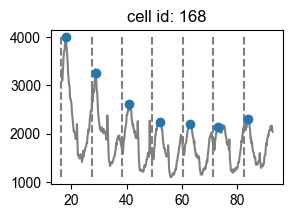

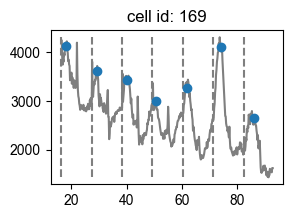

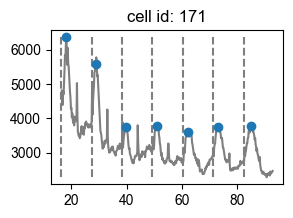

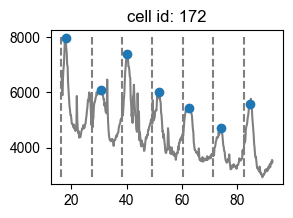

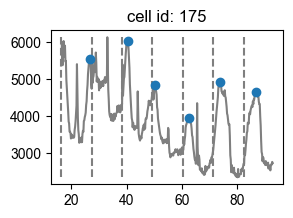

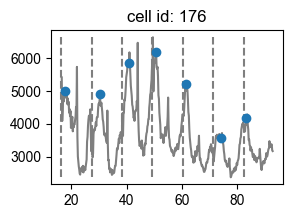

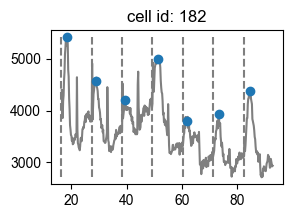

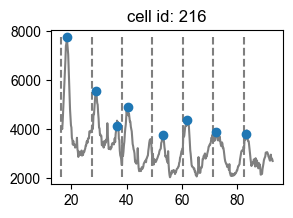

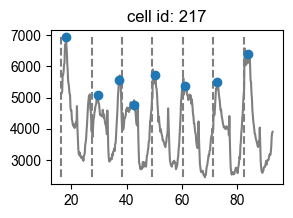

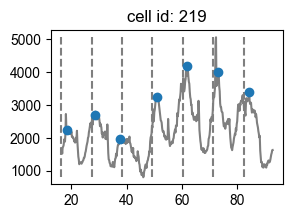

In [27]:
''' 
Nut period: 2.5, 4, 7, 8, 9, 11
Nut_conc: 0.5, (+0.25, 1, 2 at 11h of stimulus)
Smoothed_traces: False to see originals, True to see ones with smooth filter on
Entrain label : "Entrained", "Period-doubling", "Mode-hopping", "Unclassified"
Entrain mode : "Non-entrained", "0.5", "1.0", "2.0", "1.5"

Continuous gray lines are p53 traces
Blue dots are position of p53 peaks
Vertical dashed gray bars are position of nutlin when flushed IN

'''

plot_single_cells_zone2(dataset, nut_period = 11, 
                  nut_conc = 0.5, 
                  smoothed_traces = False, 
                  entrain_label = "Entrained", 
                  entrain_mode = "1.0")